# Nichesphere differential communication tutorial

## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import sklearn
import igraph as ig
warnings.filterwarnings("ignore")

## My package test
#import sys
#sys.path.append("/data/hu367653/source/Nichesphere-main/nichesphere/nichesphere")
#import tl_new
import nichesphere

One of the advantages of Nichesphere is that it allows process based localized differential communication testing by looking at changes in LR interactions involved in specific processes between niches. To do this, we will need the correspondence data between cell type pairs and niche pairs

In [2]:
pairCatDFdir=pd.read_csv('./pairCatDFdir_MIvisium.csv', index_col=0)
pairCatDFdir

,cell_pairs,niche_pairs
0,Fib1_SCARA5->Fib1_SCARA5,2_Fibro_vCM->2_Fibro_vCM
1,Fib1_SCARA5->damaged_CM,2_Fibro_vCM->1_CardioNeuro
2,Fib1_SCARA5->Capillary_Endo,2_Fibro_vCM->2_Fibro_vCM
3,Fib1_SCARA5->LYVE_FOLR_Macrophages,2_Fibro_vCM->4_MyofibImmune
4,Fib1_SCARA5->Fib3_C7,2_Fibro_vCM->4_MyofibImmune
...,...,...
1084,NK_T->NK,5_Immune->5_Immune
1085,NK_T->CD_8,5_Immune->5_Immune
1086,NK_T->Purkinje_fibers,5_Immune->5_Immune
1087,NK_T->Adipo,5_Immune->3_Macro


As well as cell types and niches

In [3]:
niches_df=pd.read_csv('./niches_df_MIvisium.csv', index_col=0)
niches_df

,cell.1,niche,color
cell,,,
Fib1_SCARA5,Fib1_SCARA5,2_Fibro_vCM,#0072B5
damaged_CM,damaged_CM,1_CardioNeuro,#BC3C29
Capillary_Endo,Capillary_Endo,2_Fibro_vCM,#0072B5
LYVE_FOLR_Macrophages,LYVE_FOLR_Macrophages,4_MyofibImmune,#4daf4a
Fib3_C7,Fib3_C7,4_MyofibImmune,#4daf4a
healthy_CM,healthy_CM,1_CardioNeuro,#BC3C29
Fib2_Myofib,Fib2_Myofib,4_MyofibImmune,#4daf4a
Endocardial_Endo,Endocardial_Endo,4_MyofibImmune,#4daf4a
Arterial_Endo,Arterial_Endo,2_Fibro_vCM,#0072B5


Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [4]:
oneCTints=niches_df.index+'-'+niches_df.index
oneCTints

Index(['Fib1_SCARA5-Fib1_SCARA5', 'damaged_CM-damaged_CM',
       'Capillary_Endo-Capillary_Endo',
       'LYVE_FOLR_Macrophages-LYVE_FOLR_Macrophages', 'Fib3_C7-Fib3_C7',
       'healthy_CM-healthy_CM', 'Fib2_Myofib-Fib2_Myofib',
       'Endocardial_Endo-Endocardial_Endo', 'Arterial_Endo-Arterial_Endo',
       'Neuronal-Neuronal', 'Pericyte_1-Pericyte_1',
       'LYVE_PLTP_Macrophages-LYVE_PLTP_Macrophages',
       'intermediate_CM-intermediate_CM', 'vCM_3-vCM_3',
       'Pericyte_2-Pericyte_2', 'Mast-Mast', 'Monocytes-Monocytes',
       'Fib4_COL15A1-Fib4_COL15A1', 'SPP1_Macrophages-SPP1_Macrophages',
       'Venous_Endo-Venous_Endo', 'vCM_4-vCM_4', 'prolif-prolif',
       'vSMCs_1-vSMCs_1', 'CCL18_Macrophages-CCL18_Macrophages',
       'perivascular_fibroblasts-perivascular_fibroblasts', 'CD_4-CD_4',
       'vSMCs_2-vSMCs_2', 'Lymphatic_Endo-Lymphatic_Endo', 'NK-NK',
       'CD_8-CD_8', 'Purkinje_fibers-Purkinje_fibers', 'Adipo-Adipo',
       'NK_T-NK_T'],
      dtype='object', name

In [5]:
niches_dict={'1_CardioNeuro':list(niches_df.index[niches_df.niche=='1_CardioNeuro']),
     '2_Fibro_vCM':list(niches_df.index[niches_df.niche=='2_Fibro_vCM']),
     '3_Macro':list(niches_df.index[niches_df.niche=='3_Macro']),
     '4_MyofibImmune':list(niches_df.index[niches_df.niche=='4_MyofibImmune']),
     '5_Immune':list(niches_df.index[niches_df.niche=='5_Immune']),
     }

We will filter cell type pairs with non significant differential co-localization scores. Cell pairs with filter=1 will be tested

In [6]:
colocFilt=pd.read_csv('./colocFilt_MIvisium.csv', index_col=0)
colocFilt

,filter
cell_pairs,
Fib1_SCARA5->Fib1_SCARA5,1.0
Fib1_SCARA5->damaged_CM,1.0
Fib1_SCARA5->Capillary_Endo,1.0
Fib1_SCARA5->LYVE_FOLR_Macrophages,0.0
Fib1_SCARA5->Fib3_C7,1.0
...,...
NK_T->vSMCs_2,0.0
NK_T->Lymphatic_Endo,0.0
NK_T->NK,0.0


Get cell communication data (CrossTalkeR tables)

In [7]:
crossTalker_ctrlComm=pd.read_csv('./crossTalker_tbl_myo_heart_exp_scSeqComm.csv', index_col=0)
crossTalker_iscComm=pd.read_csv('./crossTalker_tbl_isc_heart_exp_scSeqComm.csv', index_col=0)

In [8]:
#crossTalker_ctrlComm=crossTalker_ctrlComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

In [9]:
#crossTalker_iscComm=crossTalker_iscComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

Nichesphere is suited to work with CrossTalkeR output tables which contain columns called **cellpair**, indicating the cell types involved in an interaction separated by '@'; and **allpair**, indicating cell types, ligand and receptor involved. Additionally, input tables for Nichesphere should contain columns indicating the **ligand** (gene_A), **receptor** (gene_B) and **communication score** (MeanLR). The names for these last 3 columns can be indicated in Nichesphere functions.

CrossTalkeR tables contain strings indicating wether a gene is a ligand (|L), receptor (|R) or transcription factor (|TF). These strings will be removed as they might cause conflicts with code. 

In [10]:
crossTalker_ctrlComm=nichesphere.tl.processCTKRoutput(crossTalker_ctrlComm)
crossTalker_iscComm=nichesphere.tl.processCTKRoutput(crossTalker_iscComm)

Names of cell types need to match between communication and colocalisation data

In [11]:
crossTalker_ctrlComm

,ligand,receptor_complex,cellpair,source,target,inter_score,type_gene_A,type_gene_B,gene_A,gene_B,MeanLR,allpair,ligpair,recpair,LRScore,LRmean,LRprod,LRscSeqComm
1,A2M,LRP1,Adipo@Adipo,Adipo,Adipo,0.742349,Ligand,Receptor,A2M,LRP1,0.742349,Adipo/A2M@Adipo/LRP1,Adipo/A2M|L,Adipo/LRP1|R,0.742349,0.403849,0.066025,0.742349
2,ADAM10,EPHA3,Adipo@Adipo,Adipo,Adipo,0.937603,Ligand,Receptor,ADAM10,EPHA3,0.937603,Adipo/ADAM10@Adipo/EPHA3,Adipo/ADAM10|L,Adipo/EPHA3|R,0.937603,0.207537,0.038841,0.937603
3,ADAM12,ITGA9,Adipo@Adipo,Adipo,Adipo,0.964709,Ligand,Receptor,ADAM12,ITGA9,0.964709,Adipo/ADAM12@Adipo/ITGA9,Adipo/ADAM12|L,Adipo/ITGA9|R,0.964709,0.272629,0.061187,0.964709
4,ADAM12,ITGB1,Adipo@Adipo,Adipo,Adipo,0.999963,Ligand,Receptor,ADAM12,ITGB1,0.999963,Adipo/ADAM12@Adipo/ITGB1,Adipo/ADAM12|L,Adipo/ITGB1|R,0.999963,0.333766,0.108538,0.999963
5,ADAM17,ITGB1,Adipo@Adipo,Adipo,Adipo,0.999963,Ligand,Receptor,ADAM17,ITGB1,0.999963,Adipo/ADAM17@Adipo/ITGB1,Adipo/ADAM17|L,Adipo/ITGB1|R,0.999963,0.309172,0.094752,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217519,VEGFA,NRP1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.989853,Ligand,Receptor,VEGFA,NRP1,0.989853,vSMCs_2/VEGFA@vSMCs_2/NRP1,vSMCs_2/VEGFA|L,vSMCs_2/NRP1|R,0.989853,0.501278,0.084379,0.989853
217520,VEGFB,FLT1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.965057,Ligand,Receptor,VEGFB,FLT1,0.965057,vSMCs_2/VEGFB@vSMCs_2/FLT1,vSMCs_2/VEGFB|L,vSMCs_2/FLT1|R,0.965057,0.102204,0.010095,0.965057
217521,VEGFB,NRP1,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.999945,Ligand,Receptor,VEGFB,NRP1,0.999945,vSMCs_2/VEGFB@vSMCs_2/NRP1,vSMCs_2/VEGFB|L,vSMCs_2/NRP1|R,0.999945,0.515369,0.110020,0.999945
217522,VIM,CD44,vSMCs_2@vSMCs_2,vSMCs_2,vSMCs_2,0.627537,Ligand,Receptor,VIM,CD44,0.627537,vSMCs_2/VIM@vSMCs_2/CD44,vSMCs_2/VIM|L,vSMCs_2/CD44|R,0.627537,0.252344,0.025276,0.627537


In [12]:
allDBs=pd.read_csv('/data/hu367653/nichesphere_tutorial_data/allDBs.csv', index_col=0)
allDBs['Ligand']=allDBs['Ligand'].str.lower()
allDBs

,Ligand,category,db,ensembl_gene_id,iname,synonyms,description
2,col1a1,Collagens,matrissome,NaN,NaN,NaN,NaN
5,col1a2,Collagens,matrissome,NaN,NaN,NaN,NaN
17,col6a3,Collagens,matrissome,NaN,NaN,NaN,NaN
23,col3a1,Collagens,matrissome,NaN,NaN,NaN,NaN
30,col2a1,Collagens,matrissome,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
125,pmaip1,apoptosis,deathbase,ENSDARG00000071431,Zebrafish,phorbol-12-myristate-13-acetate-induced protei...,phorbol-12-myristate-13-acetate-induced protei...
126,tnfrsfa,apoptosis,deathbase,ENSDARG00000004451,Zebrafish,tumor necrosis factor receptor superfamily mem...,"tumor necrosis factor receptor superfamily, me..."
127,tnfsf10l,apoptosis,deathbase,ENSDARG00000004196,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."
128,tnfsf10l2,apoptosis,deathbase,ENSDARG00000057241,Zebrafish,tumor necrosis factor (ligand) superfamily mem...,"tumor necrosis factor (ligand) superfamily, me..."


Then we'll separate communication scores by process to know which cell type pairs and niche pairs are interacting through which processes in each condition.

In [13]:
myoCTpairScores_byCat2_dir_colocClusts=nichesphere.comm.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='myogenic', pairCatDF=pairCatDFdir)

In [14]:
iscCTpairScores_byCat2_dir_colocClusts=nichesphere.comm.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_iscComm, db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints.str.replace('-', '@'), condition='ischemic', pairCatDF=pairCatDFdir)

In [15]:
myoCTpairScores_byCat2_dir_colocClusts

,cell_pairs,niche_pairs,LRscores,LRcat,condition
allpair,,,,,
Adipo/COL14A1@Arterial_Endo/CD44,Adipo->Arterial_Endo,3_Macro->2_Fibro_vCM,0.717175,Collagens,myogenic
Adipo/COL14A1@CCL18_Macrophages/CD44,Adipo->CCL18_Macrophages,3_Macro->3_Macro,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_4/CD44,Adipo->CD_4,3_Macro->5_Immune,0.967985,Collagens,myogenic
Adipo/COL14A1@CD_8/CD44,Adipo->CD_8,3_Macro->5_Immune,0.967985,Collagens,myogenic
Adipo/COL14A1@Fib1_SCARA5/CD44,Adipo->Fib1_SCARA5,3_Macro->2_Fibro_vCM,0.967985,Collagens,myogenic
...,...,...,...,...,...
Venous_Endo/TNFSF10@damaged_CM/TNFRSF11B,Venous_Endo->damaged_CM,4_MyofibImmune->1_CardioNeuro,0.995297,apoptosis,myogenic
Venous_Endo/TNFSF10@prolif/TNFRSF10B,Venous_Endo->prolif,4_MyofibImmune->1_CardioNeuro,0.999923,apoptosis,myogenic
Venous_Endo/TNFSF10@prolif/TNFRSF10D,Venous_Endo->prolif,4_MyofibImmune->1_CardioNeuro,0.999857,apoptosis,myogenic


Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [16]:
myoCTpairScores_byCat2_dir_colocClusts, iscCTpairScores_byCat2_dir_colocClusts = nichesphere.comm.equalizeScoresTables(ctrlTbl=myoCTpairScores_byCat2_dir_colocClusts, 
                                                    expTbl=iscCTpairScores_byCat2_dir_colocClusts, ctrlCondition='myogenic', expCondition='ischemic')

Filter by co-localization

In [17]:
myoCTpairScores_byCat2_dir_colocClusts=myoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in myoCTpairScores_byCat2_dir_colocClusts.cell_pairs]]
iscCTpairScores_byCat2_dir_colocClusts=iscCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in iscCTpairScores_byCat2_dir_colocClusts.cell_pairs]]

Then we can test for differential cell cell communication between niche pairs or cell pairs across processes with the function 'tl.diffCcommStats'. We will first test per niche pair setting the parameter 'cellCatCol' to 'niche_pairs', which is the column in the tables of communication scores by process containing niche pairs:

In [18]:
## Differential communication statistics
myoIsc_diffCcommTable_colocGroups_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='niche_pairs')


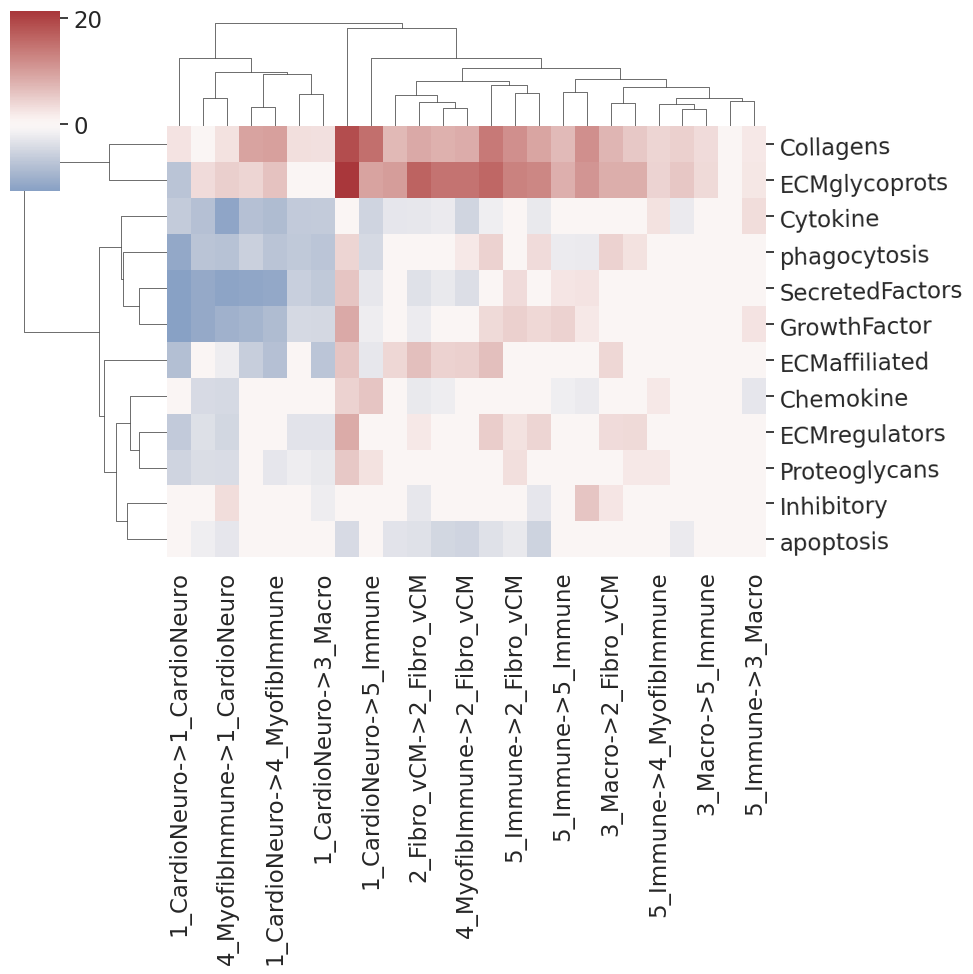

In [19]:
## Differential communication by coloc group

## Plot in heatmap
hm_df, cm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable_colocGroups_dir, min_pval=0.05)


Then we'll calculate communication scores summing scores for a specific LR pair for a specific cell type pair and separate these scores per ligand category to know which cell type pairs are interacting through which mechanisms.

Localized differential communication networks

To build process specific differential cell communication networks, we will look at differential cell communication per cell type pair per process, so we will do the differential communication test again, this time setting 'cellCatCol' to 'cell_pairs', which is the column in the tables of communication scores by process containing cell pairs

In [20]:
## Differential cell communication per cell type pair

## Differential communication statistics
myoIsc_diffCcommTable2_CTpair_dir=nichesphere.comm.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='cell_pairs')


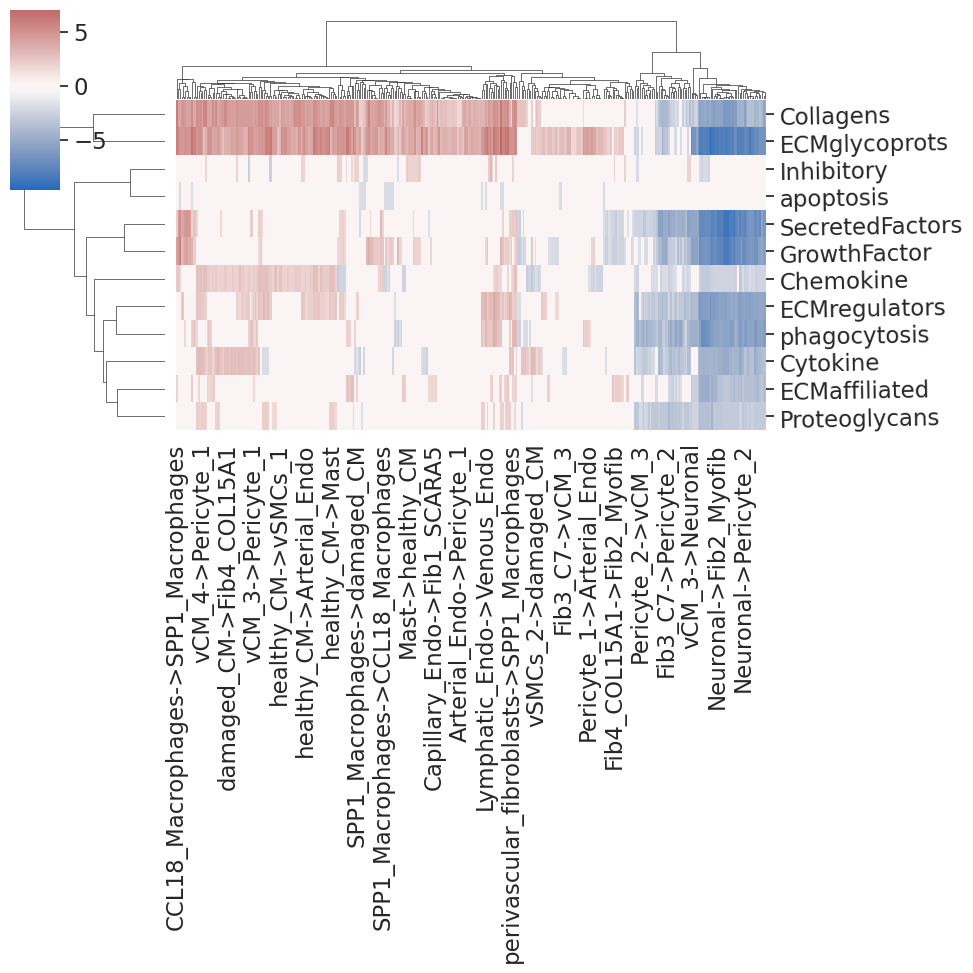

In [21]:
x_myoIsc_dir, plothm=nichesphere.comm.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable2_CTpair_dir, min_pval=0.1)

Now we can plot differential cell communication scores per process on the co-localization network

In [22]:
gCol=nx.read_graphml("./colocNW_MIvisium.graphml")

In [23]:
#Niches colors
clist=["#BC3C29", "#0072B5", "#ffff33", "#4daf4a", "#EE4C97"]

<Figure size 640x480 with 0 Axes>

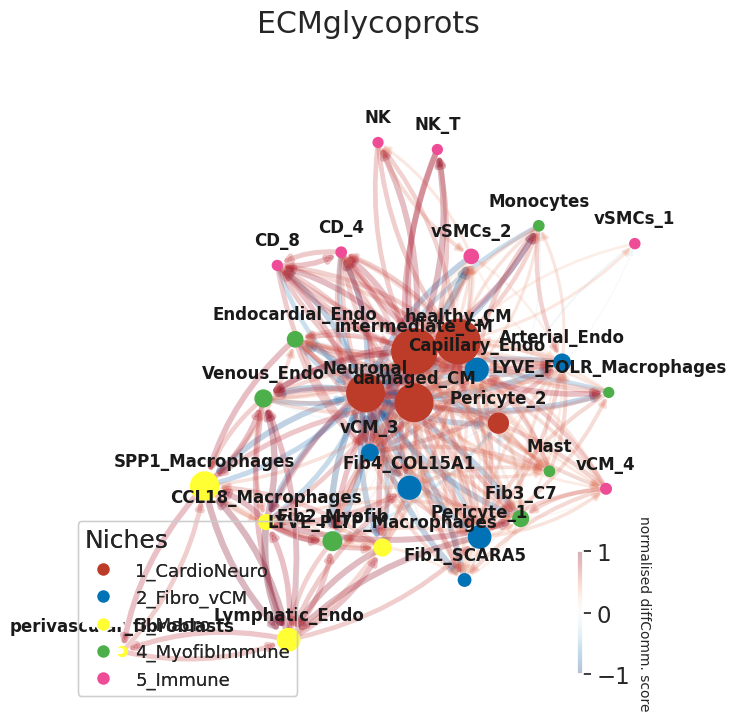

In [25]:
## Differential communication NW
plt.rcParams['axes.facecolor'] = "None"
plt.figure(frameon=False)

x_chem,adjChem=nichesphere.comm.getAdj_comm(diffCommTbl=x_myoIsc_dir, pairCatDF=pairCatDFdir, ncells=33, cat='ECMglycoprots')

G=nichesphere.comm.catNW(x_chem=x_chem,colocNW=gCol, cell_group=niches_dict, group_cmap='tab20', ncols=20, plot_title='ECMglycoprots', clist=clist, BTsizedNodes=True)
legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[0], lw=4, label='1_CardioNeuro', ms=10),
                    plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[1], lw=4, label='2_Fibro_vCM', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[2], lw=4, label='3_Macro', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[3], lw=4, label='4_MyofibImmune', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[4], lw=4, label='5_Immune', ms=10),
                ]

plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='lower left', fontsize=13, title='Niches', alignment='left'))
#plt.savefig('../../../../figures_nichesphere_tutorial/colocFilt_commNW_'+cat+'.pdf')


We can then calculate some network statistics with the networkX package [ref] functions:

In [27]:
t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 'influencer':[nx.eigenvector_centrality(G, max_iter=1000)[x] for x in list(G.nodes)]})
t1.index=list(G.nodes)

And visualize them

Text(0.5, 1.0, 'Influencer')

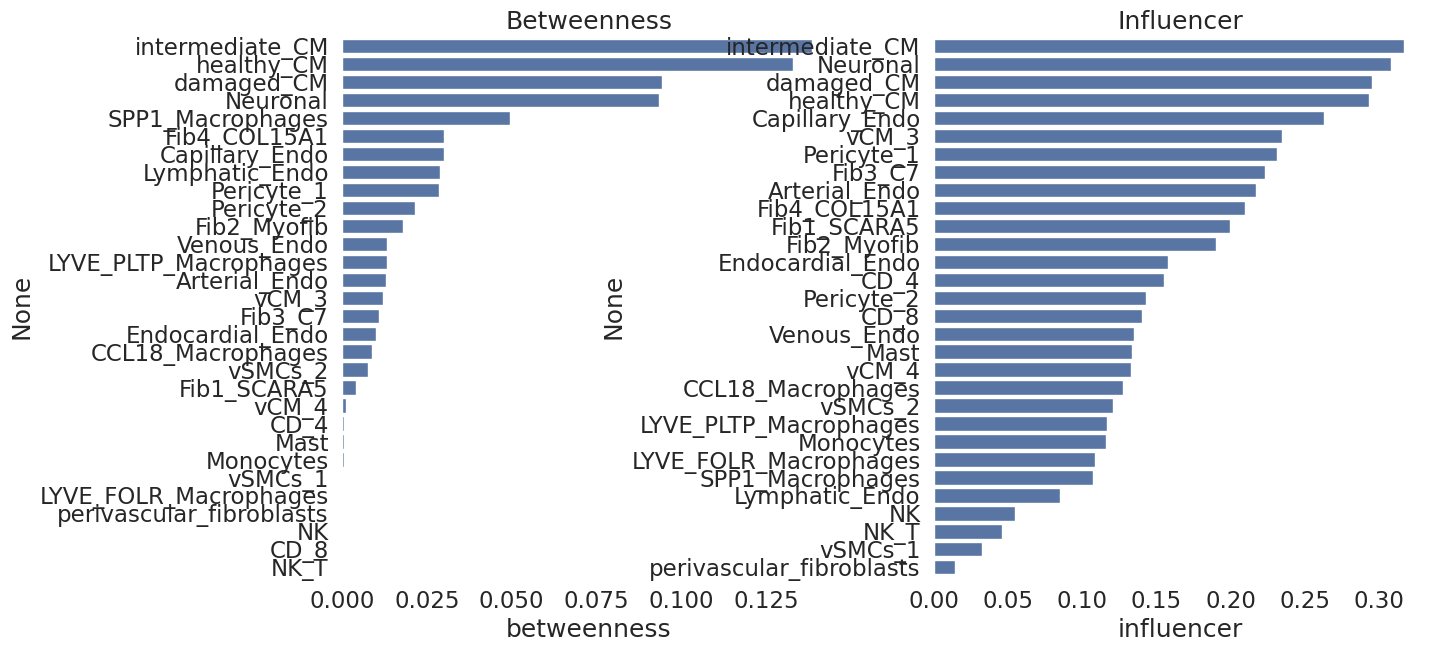

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.barplot(ax=axes[0], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[0].set_title('Betweenness')   
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')